In [15]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from urllib.request import urlopen
from json import load
sns.set_style('white')
sns.set_context('notebook')

# 1. Import Data

In [16]:
# ASC Cohort
conn = sqlite3.connect('./Data/knwlg_blf.db')
#dat1 = pd.read_sql("SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code LIKE '%XXX%'", con=conn)
dat1 = pd.read_sql("SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id "
                   "WHERE B.block1_complete=TRUE "
                   "AND B.block2_complete=TRUE "
                   "AND B.block3_complete=TRUE "
                   "AND B.completion_code LIKE '%XXX%'", con=conn)
dat1 = dat1.loc[:,~dat1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat1 = dat1.loc[dat1.trial_type == 'test'].reset_index(drop=True)
dat1['group'] = 'Autism'

# TD cohort
conn2 = sqlite3.connect('./Data/knwlg_blf_controls.db')
dat2 = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn2)
dat2 = dat2.loc[:,~dat2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat2 = dat2.loc[dat2.trial_type == 'test'].reset_index(drop=True)
dat2['email'] = 'N/A'
dat2['group'] = 'Neurotypical'

# Combine into one big dataframe
dat = pd.concat(objs=[dat1,dat2], ignore_index=True)
#
dat['email'] = dat.email.str.lower().str.strip()

# data saved for testing purposes has id as float instead of alphanumeric so only keep alphanumeric IDs
dat = dat[dat.prolific_id.str.isalnum()].reset_index(drop=True)
dat['response_key'] = dat.response_key.apply(literal_eval)

# NOTE: after September 10th, 2022, completion of recaptcha saved to database.

In [18]:
dat.loc[dat.email == 'jamesdenisee@outlook.com']#.correct.mean()
#dat.email.sort_values( axis=0).unique()

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,GMT_timestamp,email,block1_complete,block2_complete,block3_complete,completion_code,feedback,completion_time,recaptcha_complete,group


## Cleaning

## Convert SQL strings to python datetime object and compute timedeltas

In [3]:
def convert_time(x):
    if type(x) == str:
        return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

dat[['response_onset','target_onset','participation_date','completion_time']] = dat[['response_onset','target_onset','participation_date','completion_time']].applymap(convert_time)

dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

## Time to Complete

In [4]:
#dat.iloc[2]['completion_time']
dat[~dat.completion_time.isnull()].completion_time.values[0] - dat[~dat.completion_time.isnull()].participation_date.values[0]

a = dat[~dat.completion_time.isnull()].iloc[0].completion_time#.groupby('prolific_id').completion_time.count()
b = dat[~dat.completion_time.isnull()].iloc[0].participation_date#.groupby('prolific_id').completion_time.count()
b

Timestamp('2022-09-06 22:32:59.570970')

In [5]:
idx = dat[~dat.completion_time.isnull()].index
dat['study_duration'] = None
dat.loc[idx, 'study_duration'] = dat.loc[idx].completion_time - dat.loc[idx].participation_date
#dat.loc[idx].groupby('prolific_id').mean()

# 2. Accuracy

### Note where subjects entered invalid responses

In [6]:
accepted_answers = ['f', 'j', '999']
dat['accepted_answer'] = None
for i, response in enumerate(dat.response_key):
    if sum([key.lower() in accepted_answers for key in response]) >= 1:  # == len(response):
        dat.loc[i, 'accepted_answer'] = True
    else:
        dat.loc[i, 'accepted_answer'] = False

print(f"{len(dat.loc[dat.accepted_answer == False].prolific_id.unique())} participants responded at least one trial with invalid keys. \n"
      f"{len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Neurotypical')].prolific_id.unique())} of these are from the neurotypical group. \n"
      f" {len(dat.loc[(dat.accepted_answer == False)&(dat.group == 'Autism')].prolific_id.unique())} of these are from the autism group.")

101 participants responded at least one trial with invalid keys. 
16 of these are from the neurotypical group. 
 85 of these are from the autism group.


### Note trials where subjects timed-out after the 5-seconds

In [7]:
dat['timeout'] = False
# Here are timeouts without a response at all
dat.loc[dat.apply(lambda row: '999' in row['response_key'], axis=1), 'timeout'] = True
# Here is where pps pressed a key after 5 seconds, but before the experiment redirected
timeouts = dat.loc[(dat.response_key.apply(len)>1) & (dat.apply(lambda row: '999' in row['response_key'], axis=1))].index
dat.loc[timeouts, 'timeout'] = True

print(f"{len(dat.loc[dat.timeout == True].prolific_id.unique())} participants timed out during at least one trial. \n"
      f"{len(dat.loc[(dat.timeout == True)&(dat.group == 'Neurotypical')].prolific_id.unique())} of these are from the neurotypical group. \n"
      f" {len(dat.loc[(dat.timeout == True)&(dat.group == 'Autism')].prolific_id.unique())} of these are from the autism group.")

530 participants timed out during at least one trial. 
176 of these are from the neurotypical group. 
 354 of these are from the autism group.


In [8]:
# If subjects hit more than one key, use only the last one
dat['response_key'] = [resp[-1].lower() for resp in dat.response_key]

In [9]:
#  correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['correct'] = dat.apply(lambda row: row['response_key'] == row['correct_answer'], axis=1)

# timeouts are considered incorrect
dat.loc[dat.timeout == True, 'correct'] = False

## Exclude participants with mean accuracy < .6

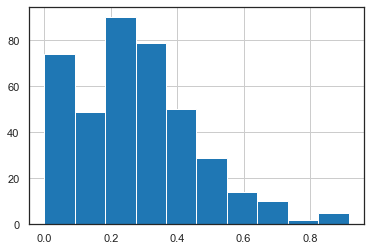

In [10]:
dat.loc[dat.group == 'Autism'].groupby('prolific_id').correct.mean().hist()

In [ ]:
print(f'N autism cohort before exclusion: {len(dat.loc[dat.group == "Autism"].prolific_id.unique())}')
## Exclude participants with mean accuracy < .6
xx = dat.groupby('prolific_id').correct.mean() > .6
dat = dat.loc[dat.prolific_id.isin(xx[xx == True].index.tolist())]

In [ ]:
print(f'N autism cohort after exclusion: {len(dat.loc[dat.group == "Autism"].prolific_id.unique())}')

In [ ]:
v_dat = dat#.loc[(dat.accepted_answer == True)]
acc = pd.DataFrame(columns=['cohort', 'agent_state', 'ascription', 'pct_correct', 'pct_incorrect'])
for gro in dat['group'].unique():
    for bel in dat.belief_type.unique():
        for ascrip in dat.ascription_type.unique():
            dd = v_dat.loc[(v_dat.group == gro)&(v_dat.belief_type==bel)&(v_dat.ascription_type==ascrip)]
            pc = len(dd.loc[dd.correct== True])/len(dd)
            ndf = pd.DataFrame({'cohort':[gro], 'agent_state':[bel], 'ascription':[ascrip], 'pct_correct':[pc], 'pct_incorrect':[1-pc]})
            acc = pd.concat([acc,ndf ], axis=0)#.reset_index(drop=True)
#sns.barplot(x='belief_type', row='group', x='ascription_type', hue='correct', kind='bar', data=)
#sns.histplot(data=v_dat, x='belief_type', hue='correct', multiple='stack', element='bars', stat='percent')

In [ ]:
import matplotlib.patches as mpatches
acc['total'] = 1
acc.melt(id_vars=['cohort', 'agent_state', 'ascription'], value_vars=['pct_correct', 'total'], value_name='Percent', var_name='Accuracy')
#sns.catplot(col='belief_type', row='group', x='correct', hue='ascription_type', kind='count', data=dat)
#dat.groupby('group').prolific_id.describe()
# bar chart 1 -> top bars (group of 'smoker=No')
#f, ax = plt.subplots(1, 2)
#bar1 = sns.barplot(x="agent_state",  y="total", hue='ascription', data=acc.loc[acc.cohort == 'Neurotypical'], color='darkblue', ax=ax[0])
#bar1a = sns.barplot(x="agent_state",  y="total", hue='ascription', data=acc.loc[acc.cohort == 'Autism'],  color='darkblue', ax=ax[1])

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
#bar2 = sns.barplot(x="agent_state",  y="pct_correct", hue='ascription', data=acc.loc[acc.cohort == 'Neurotypical'], color='darkblue', ax=ax[0])
#bar2a = sns.barplot(x="agent_state",  y="pct_correct", hue='ascription', data=acc.loc[acc.cohort == 'Autism'], color='darkblue', ax=ax[1])

bar2 = sns.catplot(x="agent_state", y="pct_correct", hue='ascription', data=acc,col='cohort', kind='bar')
# add legend


In [ ]:
total = v_dat.groupby(['belief_type', 'ascription_type'])['accepted_answer'].sum().reset_index()
correct = v_dat[v_dat.correct == True].groupby(['belief_type', 'ascription_type'])['accepted_answer'].sum().reset_index()

correct['pct'] = [i / j * 100 for i,j in zip(len(correct), len(total))]
total['pct'] = [i / j * 100 for i,j in zip(len(total), len(total))]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="belief_type",  y="pct", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="belief_type", y="pct", data=correct, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='incorrect')
bottom_bar = mpatches.Patch(color='lightblue', label='correct')
plt.legend(handles=[top_bar, bottom_bar])


In [ ]:
len(dat.loc[dat.group == 'Autism'].prolific_id.unique())

In [ ]:
len(dat.loc[dat.group == 'Autism'].prolific_id.unique())


In [ ]:
sns.catplot(col='belief_type', x='correct', hue='ascription_type', kind='count', data=dat)


## Check to make sure all responses came AFTER the target onset

In [ ]:
sum(dat.apply(lambda row: row['response_onset'] > row['target_onset'], axis=1)) == len(dat)


## Exclude subjects with mean RTs less than 1500ms or more than 4000ms

In [ ]:
xx = dat.groupby('prolific_id').rt_ms.mean() < 1500
dat = dat.loc[dat.prolific_id.isin(xx[xx == False].index.tolist())]
yy = dat.groupby('prolific_id').rt_ms.mean() > 4000
dat = dat.loc[dat.prolific_id.isin(yy[yy == False].index.tolist())]

for old, new in {'IG': 'Ignorance', 'TB': 'True Info', 'FB': 'False Info'}.items():
    dat.belief_type.replace(old, new, inplace=True)

# 3. Location

In [16]:
adat = dat.loc[dat.group == 'Autism']
adat[['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']] = None

for subj in adat.prolific_id.unique():
    addr = adat.loc[adat.prolific_id == subj, 'ip_addy'].values[0]
    url = 'https://ipinfo.io/' + addr + '/json'
    res = urlopen(url)
    #response from url(if res==None then check connection)
    data = load(res)
    try:
        adat.loc[adat.prolific_id == subj, ['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone', 'email', 'participation_date', 'study_duration']] = [data['city'], data['region'], data['country'], data['loc'], data['org'], data['postal'], data['timezone'], adat.loc[adat.prolific_id == subj, 'email'].values[0], adat.loc[adat.prolific_id == subj, 'participation_date'].values[0], adat.loc[adat.prolific_id == subj, 'study_duration'].values[0]]
    except:
        print(f'issue with id: {subj}')

<ipython-input-16-1034ab7d2aad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adat[['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']] = None
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to 

issue with id: hkaDfNtDY7Vic6Q2
issue with id: KcsjMENf2Rb52asn
issue with id: QFgA4FniYFQUJiLD
issue with id: cd1W9YvW5FmGdjut
issue with id: skxn7ToatEqrJCMk
issue with id: fAq7JhFiusgsyHBu
issue with id: FVPK1H8ewC2Sn9I8
issue with id: e6tEjiFq6RJhAeda
issue with id: 03Tn02ZnXIdPCKpV
issue with id: ZqMVfp7iexWMp6ae


In [18]:
baddies = ['hkaDfNtDY7Vic6Q2', 'KcsjMENf2Rb52asn', 'QFgA4FniYFQUJiLD', 'cd1W9YvW5FmGdjut', 'skxn7ToatEqrJCMk', 'fAq7JhFiusgsyHBu', 'FVPK1H8ewC2Sn9I8', 'e6tEjiFq6RJhAeda', '03Tn02ZnXIdPCKpV', 'ZqMVfp7iexWMp6ae' ]

for baddi in baddies:
    bd = dat.loc[dat.prolific_id == baddi]
    addr = adat.loc[adat.prolific_id == baddi, 'ip_addy'].values[0]
    url = 'https://ipinfo.io/' + addr + '/json'
    res = urlopen(url)
#response from url(if res==None then check connection)
    data = load(res)
    print(f'This person is from {data["country"]} the email: {adat.loc[adat.prolific_id == baddi, "email"].values[0]}, ip : {addr}')

This person is from NG the email: dennisfrank0634@gmail.com, ip : 102.89.34.73
This person is from NG the email: bjoe33320@gmail.com, ip : 102.89.40.49
This person is from NG the email: thomasrheott@gmail.com, ip : 102.89.32.16
This person is from NG the email: morning4447star@gmail.com, ip : 102.89.34.93
This person is from NG the email: washington111dc@gmail.com, ip : 102.89.32.56
This person is from NG the email: the90brainz@gmail.com, ip : 102.89.38.100
This person is from NG the email: marvinsjames589@gmail.com, ip : 102.89.41.212
This person is from NG the email: jasminefranklin059@gmail.com, ip : 102.89.34.252
This person is from NG the email: lovemary4240@gmail.com, ip : 102.89.43.174
This person is from NG the email: roserose42400@gmail.com, ip : 102.89.43.174


In [19]:
xx = adat.groupby(['prolific_id','participation_date', 'email', 'ip_addy','study_duration', 'city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']).correct.mean()#.sort_values('correct')
yy = xx.reset_index().sort_values('correct', axis=0)
yy

,prolific_id,participation_date,email,ip_addy,study_duration,city,region,country,loc,org,postal,timezone,correct
262,p5JLgP3WMn82fe7K,2022-09-08 15:15:51.130380,deanmichelle362@gmail.com,102.89.32.42,0 days 00:51:26.307833,Santa Clara,California,US,"37.3924,-121.9623","AS14061 DigitalOcean, LLC",95054,America/Los_Angeles,0.000000
34,5mJMsLdhcZUwGewc,2022-09-08 10:24:22.639544,la0683178@gmail.com,107.181.178.85,0 days 00:27:06.224237,Los Angeles,California,US,"34.0522,-118.2437",AS46562 Performive LLC,90009,America/Los_Angeles,0.000000
295,tBOdndfhbFLWQlLY,2022-09-08 07:09:05.696282,bobbywalsh14@outlook.com,5.62.49.86,0 days 01:39:31.869500,Miami,Florida,US,"25.7629,-80.1895",AS198605 AVAST Software s.r.o.,33131,America/New_York,0.000000
294,tBOdndfhbFLWQlLY,2022-09-08 07:09:05.696282,bobbywalsh14@outlook.com,212.102.60.150,0 days 01:39:31.869500,Miami,Florida,US,"25.7629,-80.1895",AS198605 AVAST Software s.r.o.,33131,America/New_York,0.000000
39,6Fvtqn9NlYOR24eK,2022-09-08 14:03:48.299150,fabiangeorge317@gmail.com,5.62.59.13,0 days 02:48:44.985522,Miami,Florida,US,"25.7672,-80.2059",AS198605 AVAST Software s.r.o.,33130,America/New_York,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,tnGByjBjbUzRJwyf,2022-09-07 11:11:25.458222,dave@trahans.net,191.96.227.102,0 days 00:27:41.962866,New York City,New York,US,"40.7143,-74.0060",AS174 Cogent Communications,10004,America/New_York,0.833333
235,jcOXPqMioLJNLZ3D,2022-09-06 22:32:59.570970,johnnyldudley@gmail.com,174.105.249.50,0 days 00:27:16.157435,Columbus,Ohio,US,"39.9444,-82.8903",AS10796 Charter Communications Inc,43227,America/New_York,0.916667
299,tecm5esQvBW52caO,2022-09-09 18:19:43.165667,erinddekker@gmail.com,99.246.68.49,0 days 00:28:01.329837,Toronto,Ontario,CA,"43.5771,-79.6306",AS812 Rogers Communications Canada Inc.,L5B,America/Toronto,0.916667
192,bSNCukXbOcNIXsLz,2022-09-09 01:07:53.312595,rbinjackson@gmail.com,3.88.19.57,0 days 00:34:30.886231,Ashburn,Virginia,US,"39.0437,-77.4875","AS14618 Amazon.com, Inc.",20147,America/New_York,0.916667


In [19]:
adat.loc[adat.email == 'jamesvernonwright66@gmail.com'].correct.mean()

0.5

# 2. Response Times

In [ ]:
sns.set_context('notebook', font_scale=2)
fig, ax = plt.subplots(figsize=(15, 12))
g = sns.violinplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)],
                  color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type', y='rt_ms', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
g.yaxis.set_label_text("response time (ms)")
g.xaxis.set_label_text("Agent state")
ax.xaxis.labelpad = 20

#fig.savefig('proposal_S1_control_result.png')

In [ ]:
len(dat.loc[(dat.trial_type=='test') & (dat.correct==True)].prolific_id.unique())

# 3. Felicity Judgements

In [ ]:
f_dat = pd.read_sql('SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="XXXX"', con=conn)
f_dat = f_dat.loc[:,~f_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# 1= "Sounds very weird"
# 7 = "Sounds very normal"
f_dat['Infelicity Rating'] = 8 - f_dat.felicity_rating

In [ ]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1, order=['TB', 'IG', 'FB'])

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='fel_belief_type', y=jitter(f_dat['Infelicity Rating'], 0), hue='fel_ascription_type', data=f_dat,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['TB', 'IG', 'FB'])
g= sns.pointplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['TB', 'IG', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

# 4. AQ-10

In [16]:

a_dat =  pd.read_sql("SELECT * FROM autism_scores A INNER JOIN subjects B ON A.prolific_id = B.prolific_id "
                   "WHERE B.block1_complete=TRUE "
                   "AND B.block2_complete=TRUE "
                   "AND B.block3_complete=TRUE "
                   "AND B.completion_code LIKE '%XXX%'", con=conn)
a_dat = a_dat.loc[:,~a_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

#a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat.describe()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,AQ_rating_10,block1_complete,block2_complete,block3_complete
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.0,317.0,317.0
mean,202.769716,2.908517,2.984227,2.927445,3.015773,3.126183,3.018927,2.927445,3.041009,3.069401,2.933754,1.0,1.0,1.0
std,109.844888,0.890077,0.735452,0.836908,0.752467,0.773273,0.758676,0.806091,0.768170,0.747301,0.837433,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
25%,101.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,1.0,1.0
50%,208.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.0,1.0,1.0
75%,297.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,1.0,1.0,1.0
max,389.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.0,1.0,1.0


In [17]:
a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique().tolist())]

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,...,operating_sys,operating_sys_lang,GMT_timestamp,email,block1_complete,block2_complete,block3_complete,completion_code,feedback,completion_time
1,15,3,3,3,2,3,3,3,3,3,...,None,None,2022-08-31 09:03:51.471330,Davidbrown82021@outlook.com,1,1,1,XXXY,No,None
2,16,4,3,4,3,4,3,4,3,4,...,None,None,2022-08-31 09:04:08.411898,shellywaver@gmail.com,1,1,1,XXXY,it was great playing the games and survey,None
3,17,1,3,1,2,2,3,2,2,3,...,None,None,2022-08-31 09:05:23.406315,alan19james93@gmail.com,1,1,1,XXXY,no,None
4,18,3,2,1,4,2,1,3,4,1,...,None,None,2022-08-31 09:09:34.647299,sakirudeenk001@gmail.com,1,1,1,XXXY,Its nice,None
5,19,3,3,2,3,3,3,2,3,3,...,None,None,2022-08-31 09:15:52.996031,donnatravis545@gmail.com,1,1,1,XXXY,It is all easy and straightforward,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,385,3,3,3,3,3,3,3,3,3,...,None,None,2022-09-09 20:11:04.772743,gasno768@tapi.re,1,1,1,XXXX,,2022-09-09 16:46:28.693527
313,386,3,3,3,3,3,3,3,3,3,...,None,None,2022-09-09 20:11:11.521110,matthewjack865@gmail.com,1,1,1,XXXX,,2022-09-09 16:37:41.942885
314,387,3,3,3,3,3,3,3,3,3,...,None,None,2022-09-09 20:13:10.771414,arebum170@digdig.org,1,1,1,XXXX,,2022-09-09 16:39:08.144901
315,388,3,3,3,3,3,3,3,3,3,...,None,None,2022-09-09 20:13:59.522832,oatbadgum@ichigo.me,1,1,1,XXXX,,2022-09-09 16:47:40.492398


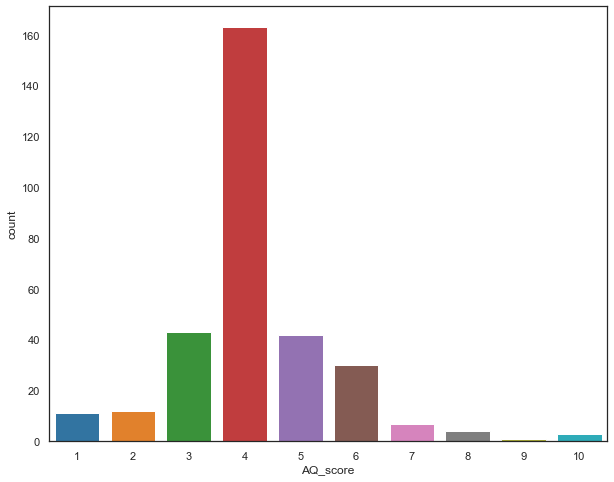

In [18]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)
a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique().tolist())]

fg, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=a_dat, x='AQ_score', ax=ax);

In [ ]:
e_dat.groupby('diag').describe()

In [ ]:
cdat = dat.loc[dat.correct ==True]
for subject in dat.prolific_id.unique():
    # calculate mean RT for belief ascription
    a_dat.loc[a_dat.prolific_id == subject, 'avg_ThinkRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Thinks')].rt_ms.mean()
    a_dat.loc[a_dat.prolific_id == subject, 'avg_KnowRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Knows')].rt_ms.mean()

a_dat['RT_diff'] = a_dat.apply(lambda row: row['avg_ThinkRT'] - row['avg_KnowRT'], axis=1)


In [ ]:
sns.lmplot(x='AQ_score', y='RT_diff', data=a_dat);
